# Feature Engineering 

In this notebook we'll start with a lightly cleaned version of the CSC dataset. We'll go through the following steps:

* Examine and visualize missing data. 
* Determine where it's appropriate to drop records, and the right way to impute missing values for remaining records.
* Bin some of our numeric features. 
* Condense our offence descriptions. 
* OneHot & ordinal encode our variables. 
* Reshape dataframe so that each record is an inmate in a particular year. 

Let's start by importing our packages and reading in the data.

In [1]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

In [2]:
#Read in CSV
df = pd.read_csv('cleaned_data.csv', index_col=0)

#Make sure all rows are displayed 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [3]:
df.head()

,FISCAL YEAR,SENTENCE ID,OFFENDER NUMBER,RACE,RACE GROUPING,GENDER,AGE,IN CUSTODY/COMMUNITY,SUPERVISION TYPE,JURISDICTION,SENTENCE TYPE,AGGREGATE SENTENCE LENGTH,INSTITUTIONAL SECURITY LEVEL,PROVINCE,LOCATION TYPE,OFFENDER SECURITY LEVEL,DYNAMIC/NEED,STATIC/RISK,REINTEGRATION POTENTIAL,MOTIVATION,RELIGION,WARRANT ID,COURT,OFFENCE ID,OFFENCE DESCRIPTION,RACIAL CATEGORY,SENTENCE LENGTH (YEARS)
0,11-12,U40A00014615,82.50710,White,Non Indigenous,MALE,23,In Custody,NaN,FEDERAL,DETERMINATE,1096.0,MINIMUM,ONTARIO,FEDERAL INSTITU,MINIMUM,MEDIUM,LOW,HIGH,HIGH,CHRI NON SPEC,U40A00081680,ONT COURT OF JUSTICE,U40A00073751,POSS PROH/RESTR F/ARM W/AMMUN,White,3.00
1,11-12,U40A00014615,82.50710,White,Non Indigenous,MALE,23,In Custody,NaN,FEDERAL,DETERMINATE,1096.0,MINIMUM,ONTARIO,FEDERAL INSTITU,MINIMUM,MEDIUM,LOW,HIGH,HIGH,CHRI NON SPEC,U40A00081680,ONT COURT OF JUSTICE,U40A00073752,FAIL TO COMPLY W/ PROBATION ORDER,White,3.00
2,11-12,U40A00014615,82.50710,White,Non Indigenous,MALE,23,In Custody,NaN,FEDERAL,DETERMINATE,1096.0,MINIMUM,ONTARIO,FEDERAL INSTITU,MINIMUM,MEDIUM,LOW,HIGH,HIGH,CHRI NON SPEC,U40A00081680,ONT COURT OF JUSTICE,U40A00073753,POSS SCHEDULE I/II SUBST FOR PURP TRAFF,White,3.00
3,11-12,U80A00008369,104.76347,White,Non Indigenous,MALE,39,In Custody,NaN,FEDERAL,DETERMINATE,732.0,MEDIUM,BRITISH COLUMBI,FEDERAL INSTITU,MEDIUM,HIGH,HIGH,LOW,MEDIUM,NONE,U80A00048789,VANCOUVER PROVINCIAL COURT,U80A00029774,ASSAULT - USE OF FORCE,White,2.01
4,11-12,U80A00008369,104.76347,White,Non Indigenous,MALE,39,In Custody,NaN,FEDERAL,DETERMINATE,732.0,MEDIUM,BRITISH COLUMBI,FEDERAL INSTITU,MEDIUM,HIGH,HIGH,LOW,MEDIUM,NONE,U80A00048789,VANCOUVER PROVINCIAL COURT,U80A00029785,ROBBERY - ALL OTHERS,White,2.01


## Visualizing Missing Data

Let's get a summary of our null values, and then visualize it using the `missingno` package.

In [4]:
df.shape

(731785, 27)

In [5]:
df.isnull().sum()

FISCAL YEAR                          0
SENTENCE ID                          0
OFFENDER NUMBER                      0
RACE                                 0
RACE GROUPING                        0
GENDER                               0
AGE                                  0
IN CUSTODY/COMMUNITY                 0
SUPERVISION TYPE                467091
JURISDICTION                         0
SENTENCE TYPE                        0
AGGREGATE SENTENCE LENGTH            0
INSTITUTIONAL SECURITY LEVEL    233677
PROVINCE                             0
LOCATION TYPE                        0
OFFENDER SECURITY LEVEL          44539
DYNAMIC/NEED                     18744
STATIC/RISK                      18526
REINTEGRATION POTENTIAL          19278
MOTIVATION                       19600
RELIGION                         42563
WARRANT ID                           0
COURT                            10772
OFFENCE ID                           0
OFFENCE DESCRIPTION                  0
RACIAL CATEGORY          

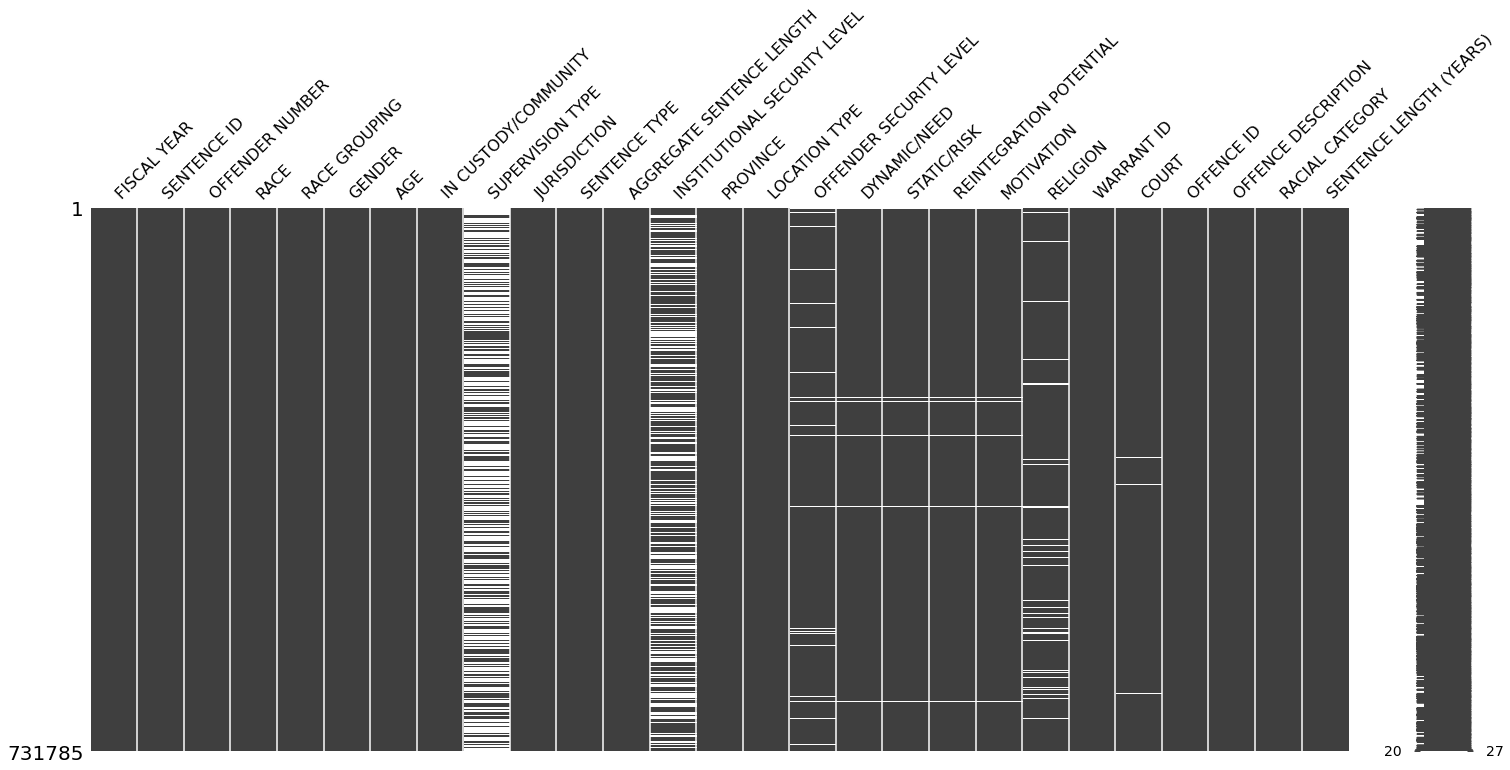

In [6]:
msno.matrix(df)
plt.show()

From the counts we can see that the 'supervision type' and 'instutitional security level' columns have the most NaNs, with a couple more in the 'offender security level' and 'religion' columns. Interestingly, our NaN matrix shows us that there are a couple of records that are missing data in many of our records of interest ('offender security level', 'dynamic/need', 'static/risk', 'reintegration potential', 'motivation'). 

Let's plot a NaN heatmap to look at the correlation in the existence of NaNs across columns.

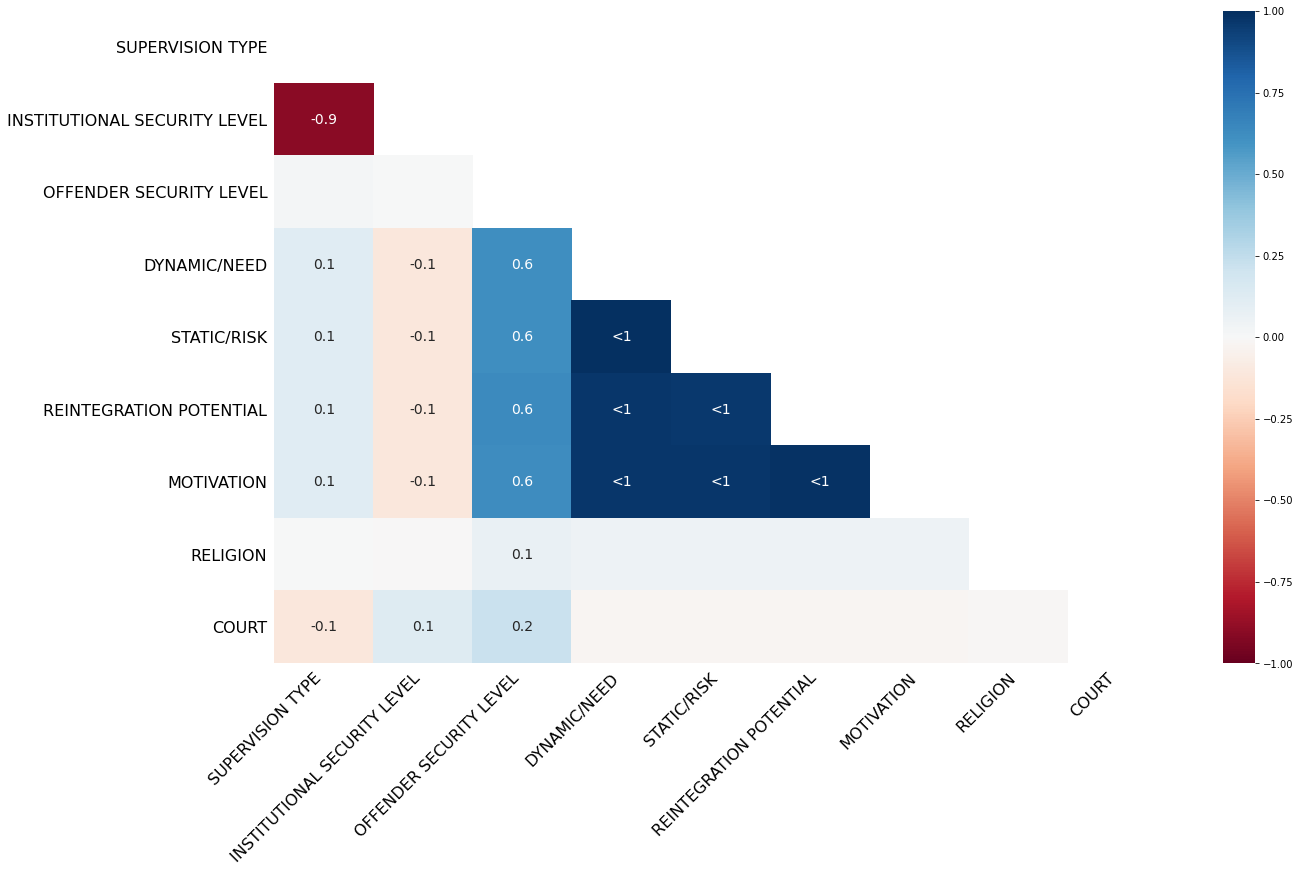

In [7]:
msno.heatmap(df)
plt.show()

We have confirmation about the correlation between missing scores of various kinds - if a score is missing in one column, it's likely to be missing in others. Additionally, we have a strong negative correlation between 'institutional security level' and 'supervision type'. This is because if an offender is supervised, they are out in the community, which means they shouldn't have an institutional security level assigned since they're not in custody. 

We have some NaNs in the 'court' and 'religion' columns. Let's see how many values there are in these columns. 

In [8]:
print(df['COURT'].nunique(), df['RELIGION'].nunique())

241 70


There are quite a number of values in both of these columns - from the EDA we've also seen that there isn't an overwhelming number of individuals practising a particular religion/ attending a particular court, so it would be difficult to impute these values. That said, it's more likely that the features around an individual's security risk, prison term, etc. are indicative of their reintegration potential than their faith or the particular court they were convicted in, so I'm not too troubled by this result. But we can include a smaller dataframe with the records that don't have NaNs in these two columns as one of our modelling options to ensure we're exploring all possibilities.

After examining the structure of our NaNs, we have a good sense of next steps:

* Since there's such a strong relationship between NaNs in the 'offender security level', 'dynamic/need', 'static/risk', 'reintegration potential', and 'motivation' columns, we're going to drop all records that have are NaNs for 'reintegration potential', which will take care of the majority of NaNs in the remaining columns. We've chosen this column since it's going to be our target. 
* We'll code the 'supervision type' NaNs to return the category of 'In Custody' and the institutional security level NaNs to return the category of 'Community'.
* We'll drop the 'religion' and 'court' columns.
* Where NaNs remain in the categorical columns, we'll impute using KNN imputer.

## Dealing with NaNs 

Let's begin by dropping the records that have NaNs in the 'reintegration potential' column.

In [9]:
df.dropna(subset = ["REINTEGRATION POTENTIAL"], inplace=True)
df.shape

(712507, 27)

In [10]:
df.isnull().sum()

FISCAL YEAR                          0
SENTENCE ID                          0
OFFENDER NUMBER                      0
RACE                                 0
RACE GROUPING                        0
GENDER                               0
AGE                                  0
IN CUSTODY/COMMUNITY                 0
SUPERVISION TYPE                447826
JURISDICTION                         0
SENTENCE TYPE                        0
AGGREGATE SENTENCE LENGTH            0
INSTITUTIONAL SECURITY LEVEL    233664
PROVINCE                             0
LOCATION TYPE                        0
OFFENDER SECURITY LEVEL          25581
DYNAMIC/NEED                       300
STATIC/RISK                        286
REINTEGRATION POTENTIAL              0
MOTIVATION                         322
RELIGION                         40120
WARRANT ID                           0
COURT                            10771
OFFENCE ID                           0
OFFENCE DESCRIPTION                  0
RACIAL CATEGORY          

Now we have significantly fewer NaNs in the other assessment columns. We'll impute these with KNN imputer down the line. Let's move on to accounting for the NaNs in 'supervision type' and 'institutional security level'. 

In [11]:
#Define function to replace supervision NaNs
def replace_sup_nans(x):
    if pd.isnull(x):
        return 'In Custody'
    else:
        return x
    
#Define function to replace security level NaNs
def replace_security_nans(x):
    if pd.isnull(x):
        return 'Community'
    else:
        return x

#Map our functions on their respective columns
df['SUPERVISION TYPE'] = df['SUPERVISION TYPE'].map(replace_sup_nans)
df['INSTITUTIONAL SECURITY LEVEL'] = df['INSTITUTIONAL SECURITY LEVEL'].map(replace_security_nans)

df.isnull().sum()

FISCAL YEAR                         0
SENTENCE ID                         0
OFFENDER NUMBER                     0
RACE                                0
RACE GROUPING                       0
GENDER                              0
AGE                                 0
IN CUSTODY/COMMUNITY                0
SUPERVISION TYPE                    0
JURISDICTION                        0
SENTENCE TYPE                       0
AGGREGATE SENTENCE LENGTH           0
INSTITUTIONAL SECURITY LEVEL        0
PROVINCE                            0
LOCATION TYPE                       0
OFFENDER SECURITY LEVEL         25581
DYNAMIC/NEED                      300
STATIC/RISK                       286
REINTEGRATION POTENTIAL             0
MOTIVATION                        322
RELIGION                        40120
WARRANT ID                          0
COURT                           10771
OFFENCE ID                          0
OFFENCE DESCRIPTION                 0
RACIAL CATEGORY                     0
SENTENCE LEN

Now we're left with the offender security level before imputing. Let's look at what this column looks like:

In [12]:
df.groupby('OFFENDER SECURITY LEVEL')['OFFENDER NUMBER'].count()

OFFENDER SECURITY LEVEL
MAXIMUM     98703
MEDIUM     401090
MINIMUM    187133
Name: OFFENDER NUMBER, dtype: int64

It looks like the majority of individuals are in the 'Medium' classification of offender security level so our first instinct might be to assign that to our NaN values. However, from our EDA notebook we saw that 93% of offenders had the same offender security level as their institutional security level. Since we have no NaNs in that column, let's use those values to fill the NaNs for offender security level.

In [13]:
df['OFFENDER SECURITY LEVEL'].fillna(df['INSTITUTIONAL SECURITY LEVEL'],inplace=True)
df.isnull().sum()

FISCAL YEAR                         0
SENTENCE ID                         0
OFFENDER NUMBER                     0
RACE                                0
RACE GROUPING                       0
GENDER                              0
AGE                                 0
IN CUSTODY/COMMUNITY                0
SUPERVISION TYPE                    0
JURISDICTION                        0
SENTENCE TYPE                       0
AGGREGATE SENTENCE LENGTH           0
INSTITUTIONAL SECURITY LEVEL        0
PROVINCE                            0
LOCATION TYPE                       0
OFFENDER SECURITY LEVEL             0
DYNAMIC/NEED                      300
STATIC/RISK                       286
REINTEGRATION POTENTIAL             0
MOTIVATION                        322
RELIGION                        40120
WARRANT ID                          0
COURT                           10771
OFFENCE ID                          0
OFFENCE DESCRIPTION                 0
RACIAL CATEGORY                     0
SENTENCE LEN

Finally, we will impute the couple of hundred remaining values in the 'dynamic/need', 'static/risk', and 'motivation' columns by taking the mode of the column when grouped by the reintegration potential.

In [14]:
df['STATIC/RISK'] = df.groupby(['OFFENDER SECURITY LEVEL','REINTEGRATION POTENTIAL'], sort=False)['STATIC/RISK'].apply(lambda x: x.fillna(x.mode().iloc[0]))
df['DYNAMIC/NEED'] = df.groupby(['OFFENDER SECURITY LEVEL','REINTEGRATION POTENTIAL'], sort=False)['DYNAMIC/NEED'].apply(lambda x: x.fillna(x.mode().iloc[0]))
df['MOTIVATION'] = df.groupby(['OFFENDER SECURITY LEVEL','REINTEGRATION POTENTIAL'], sort=False)['MOTIVATION'].apply(lambda x: x.fillna(x.mode().iloc[0]))

df.isnull().sum()

FISCAL YEAR                         0
SENTENCE ID                         0
OFFENDER NUMBER                     0
RACE                                0
RACE GROUPING                       0
GENDER                              0
AGE                                 0
IN CUSTODY/COMMUNITY                0
SUPERVISION TYPE                    0
JURISDICTION                        0
SENTENCE TYPE                       0
AGGREGATE SENTENCE LENGTH           0
INSTITUTIONAL SECURITY LEVEL        0
PROVINCE                            0
LOCATION TYPE                       0
OFFENDER SECURITY LEVEL             0
DYNAMIC/NEED                        0
STATIC/RISK                         0
REINTEGRATION POTENTIAL             0
MOTIVATION                          0
RELIGION                        40120
WARRANT ID                          0
COURT                           10771
OFFENCE ID                          0
OFFENCE DESCRIPTION                 0
RACIAL CATEGORY                     0
SENTENCE LEN

Now we only have NaNs in our 'religion' and 'court' columns. 

## Feature Engineering 

In this section of the exploration we will:

* Bin our numeric features (Age, Sentence Length).
* Condense our offence descriptions.
* Condense the number of racial categories. 

We'll be using adaptive binning for our age and sentence length columns. This way we can avoid having overly sparse or packed bins, which would happen if we were manually binning. The adaptive binning technique that's used below is quantile based binning, using 20% quantiles throughout. 

In [15]:
#Get list of quantiles
quantile_list = [0, .2, .4, .6, .8, 1.]

#Labels for our values
quantile_labels = ['0-20Q', '20-40Q', '40-60Q', '60-80Q', '80-100Q']

#Create new columns with quantile cuts
df['AGE_QRANGE'] = pd.qcut(df['AGE'], q=quantile_list, labels=quantile_labels)
df['SL_QRANGE'] = pd.qcut(df['SENTENCE LENGTH (YEARS)'], q=quantile_list, labels=quantile_labels)

df.head()

,FISCAL YEAR,SENTENCE ID,OFFENDER NUMBER,RACE,RACE GROUPING,GENDER,AGE,IN CUSTODY/COMMUNITY,SUPERVISION TYPE,JURISDICTION,SENTENCE TYPE,AGGREGATE SENTENCE LENGTH,INSTITUTIONAL SECURITY LEVEL,PROVINCE,LOCATION TYPE,OFFENDER SECURITY LEVEL,DYNAMIC/NEED,STATIC/RISK,REINTEGRATION POTENTIAL,MOTIVATION,RELIGION,WARRANT ID,COURT,OFFENCE ID,OFFENCE DESCRIPTION,RACIAL CATEGORY,SENTENCE LENGTH (YEARS),AGE_QRANGE,SL_QRANGE
0,11-12,U40A00014615,82.50710,White,Non Indigenous,MALE,23,In Custody,In Custody,FEDERAL,DETERMINATE,1096.0,MINIMUM,ONTARIO,FEDERAL INSTITU,MINIMUM,MEDIUM,LOW,HIGH,HIGH,CHRI NON SPEC,U40A00081680,ONT COURT OF JUSTICE,U40A00073751,POSS PROH/RESTR F/ARM W/AMMUN,White,3.00,0-20Q,20-40Q
1,11-12,U40A00014615,82.50710,White,Non Indigenous,MALE,23,In Custody,In Custody,FEDERAL,DETERMINATE,1096.0,MINIMUM,ONTARIO,FEDERAL INSTITU,MINIMUM,MEDIUM,LOW,HIGH,HIGH,CHRI NON SPEC,U40A00081680,ONT COURT OF JUSTICE,U40A00073752,FAIL TO COMPLY W/ PROBATION ORDER,White,3.00,0-20Q,20-40Q
2,11-12,U40A00014615,82.50710,White,Non Indigenous,MALE,23,In Custody,In Custody,FEDERAL,DETERMINATE,1096.0,MINIMUM,ONTARIO,FEDERAL INSTITU,MINIMUM,MEDIUM,LOW,HIGH,HIGH,CHRI NON SPEC,U40A00081680,ONT COURT OF JUSTICE,U40A00073753,POSS SCHEDULE I/II SUBST FOR PURP TRAFF,White,3.00,0-20Q,20-40Q
3,11-12,U80A00008369,104.76347,White,Non Indigenous,MALE,39,In Custody,In Custody,FEDERAL,DETERMINATE,732.0,MEDIUM,BRITISH COLUMBI,FEDERAL INSTITU,MEDIUM,HIGH,HIGH,LOW,MEDIUM,NONE,U80A00048789,VANCOUVER PROVINCIAL COURT,U80A00029774,ASSAULT - USE OF FORCE,White,2.01,40-60Q,20-40Q
4,11-12,U80A00008369,104.76347,White,Non Indigenous,MALE,39,In Custody,In Custody,FEDERAL,DETERMINATE,732.0,MEDIUM,BRITISH COLUMBI,FEDERAL INSTITU,MEDIUM,HIGH,HIGH,LOW,MEDIUM,NONE,U80A00048789,VANCOUVER PROVINCIAL COURT,U80A00029785,ROBBERY - ALL OTHERS,White,2.01,40-60Q,20-40Q


Now that we've dealt with binning the continuous numeric variables, we can move onto the categorical variables. Let's start by condensing our 'racial category' column from 10 unique values to 4 (grouping as 'White', 'Indigenous', 'Black', and 'Other'). We will then look at the top offence descriptions and keep the unique values that account for the majority of our offenders.

In [16]:
#Define a dict to map races to 'other' category
race_cat = {('Middle Eastern/ West Asian','East Asian','South Asian','Hispanic', 'Oceania', 'Multi-Ethic'):'Other'}

race_dict = {}
for k, v in race_cat.items():
    for key in k:
        race_dict[key] = v
        
race_dict['Other'] = 'Other'
race_dict['White'] = 'White'
race_dict['Black'] = 'Black'
race_dict['Indigenous'] = 'Indigenous'

#Map dict to current 'racial category' column
df['RACIAL CATEGORY'] = df['RACIAL CATEGORY'].map(race_dict)

#Look at unique values - should be 4
df['RACIAL CATEGORY'].unique()

array(['White', 'Indigenous', 'Other', 'Black'], dtype=object)

Let's now get a sense of how many unique offence descriptions we have.

In [17]:
df['OFFENCE DESCRIPTION'].nunique()

738

Quite a bit - that would be computationally expensive to encode into dummies, and might make our models inefficient. Let's see how many records are accounted for if we take the top 100 offence descriptions.

In [18]:
top_desc = df.groupby('OFFENCE DESCRIPTION')['OFFENCE ID'].count().sort_values(ascending=False)[:100]
bottom_desc = df.groupby('OFFENCE DESCRIPTION')['OFFENCE ID'].count().sort_values(ascending=False)[100:]
top_desc.sum()

622645

The top 100 offence descriptions account for 87% of our records - let's keep these and encode the rest of the offence descriptions as 'other'.

In [19]:
#Turn our groupby object into a list 
not_list_desc = bottom_desc.index.tolist()

#Map all descriptions in the list to the 'other' category
off_desc = {tuple(not_list_desc):'Other'}

off_dict = {}
for k, v in off_desc.items():
    for key in k:
        off_dict[key] = v

#Create a condensed offence description column mapped to our 'other' description, then fill the NaNs with their original values 
df['CONDENSED OFFENCE DESCRIPTION'] = df['OFFENCE DESCRIPTION'].map(off_dict)
df['CONDENSED OFFENCE DESCRIPTION'].fillna(df['OFFENCE DESCRIPTION'],inplace=True)

#Show that we have 101 descrptions - our 100 top counts plus 1 for 'other'
df['CONDENSED OFFENCE DESCRIPTION'].nunique()

101

Finally, let's change our 'year' field to something more readable:

In [20]:
df['YEAR'] = df['FISCAL YEAR'].apply(lambda x: '20' + x[-2:])

Now that we've dealt with NaNs and finished up our feature engineering, let's move on to encoding our features. 

## Encoding 

Before we encode, we'll filter our records and drop some columns that aren't going to be used in the exploration. We will filter for:

* Male offenders
* Federal offenders 

We will then drop the following columns:

* Age
* Fiscal Year
* Gender
* Jurisdiction
* Sentence ID
* Offence ID 
* Race 
* Race grouping 
* Sentence type 
* Aggregate sentence length
* Province
* Religion
* Warrant ID
* Court
* Offence Description
* Sentence length (years)

We'll make the following adjustments to our variables:

* Ordinal encode 'institutional security level', 'offender security level', 'dynamic/need', 'static/risk', 'reintegration potential', and 'motivation'.
* One Hot encode 'racial category', 'age qrange', 'sentence length qrange', 'in custody/community', 'supervision type', and 'condensed offence description'.

Let's filter our records:

In [21]:
#Filter for only male records 
df = df[df['GENDER']=='MALE'].reset_index(drop=True)

#Filter for only federal offenders
df = df[df['JURISDICTION']=='FEDERAL'].reset_index(drop=True)

Now let's condense our dataframe to only relevant columns

In [22]:
df_clean = df.drop(['GENDER', 'AGE', 'JURISDICTION', 'SENTENCE ID', 'LOCATION TYPE', 'OFFENCE ID', 'RACE', 'RACE GROUPING', 'SENTENCE TYPE', 'AGGREGATE SENTENCE LENGTH', 'PROVINCE', 'RELIGION', 'WARRANT ID', 'COURT', 'OFFENCE DESCRIPTION', 'SENTENCE LENGTH (YEARS)', 'FISCAL YEAR'], axis=1)

Finally, let's make encode our variables so we can feed them into our models. We'll one-hot encode and ordinal encode where appropriate.

#### Ordinal Encoding

We will be ordinal encoding 'institutional security level', 'offender security level', 'dynamic/need', 'static/risk', 'reintegration potential', and 'motivation'.

In [23]:
#Define dicts for ordinal encoding
security_dict = {'Community': 0, 'MINIMUM': 1, 'MEDIUM':2, 'MULTI-LEVEL': 3, 'MAXIMUM':4}
dyn_stat_dict = {'LOW': 0, 'MEDIUM': 1, 'HIGH': 2}
reint_motiv_dict = {'HIGH':0, 'MEDIUM':1, 'LOW': 2}

#Security dict mapping 
df_clean['OFFENDER SECURITY LEVEL'] = df_clean['OFFENDER SECURITY LEVEL'].map(security_dict)
df_clean['INSTITUTIONAL SECURITY LEVEL'] = df_clean['INSTITUTIONAL SECURITY LEVEL'].map(security_dict)

#Dynamic/ static mapping 
df_clean['DYNAMIC/NEED'] = df_clean['DYNAMIC/NEED'].map(dyn_stat_dict)
df_clean['STATIC/RISK'] = df_clean['STATIC/RISK'].map(dyn_stat_dict)

#Reintegration potential/ motivation mapping
df_clean['REINTEGRATION POTENTIAL'] = df_clean['REINTEGRATION POTENTIAL'].map(reint_motiv_dict)
df_clean['MOTIVATION'] = df_clean['MOTIVATION'].map(reint_motiv_dict)

#### One-Hot Encoding

We will be one-hot encoding 'racial category', 'age qrange', 'sentence length qrange', 'in custody/community', 'supervision type', and 'condensed offence description'.

First, we will one-hot encode the 'condensed offence description', grouping by offender number and year given that the reintegration potential score is calculated annually for each offender.

In [24]:
# Dummify offence description column
offence_dummies = pd.get_dummies(df_clean['CONDENSED OFFENCE DESCRIPTION'], prefix='offence')

# Select all columns other than Offence Description 
df_other = df_clean.drop(['CONDENSED OFFENCE DESCRIPTION'], axis=1)

# Group dataframe by Offender ID and year (i.e., one row for each unique reintegration potential assessment)
# All values are the same across each set of grouped rows, so taking the max will retrieve those values
df_other_grouped = df_other.groupby(['OFFENDER NUMBER', 'YEAR']).max()

# Add dummy columns to dataframe's Offender ID & year columns
df_off_dummies = pd.concat([df_clean[['OFFENDER NUMBER', 'YEAR']], offence_dummies], axis=1)

# Group dataframe and take the sum
df_off_sum = df_off_dummies.groupby(['OFFENDER NUMBER', 'YEAR']).sum()

# Add summed dummy columns to others
df_final = pd.concat([df_other_grouped, df_off_sum], axis=1).reset_index(drop= True)

Now we will one-hot encode the remaining columns.

In [29]:
df_final = pd.get_dummies(df_final, prefix = ['RACE','AGE','SENLENGTH','CUSTODY','SUPERVISION'], columns=['RACIAL CATEGORY','AGE_QRANGE','SL_QRANGE','IN CUSTODY/COMMUNITY','SUPERVISION TYPE'])

In [30]:
df_final.head()

,INSTITUTIONAL SECURITY LEVEL,OFFENDER SECURITY LEVEL,DYNAMIC/NEED,STATIC/RISK,REINTEGRATION POTENTIAL,MOTIVATION,offence_AGGRAVATED ASSAULT,offence_ARMED ROBBERY,offence_ARSON - DAMAGE TO PROPERTY,offence_ASSAULT - THREATS OF VIOLENCE,offence_ASSAULT - USE OF FORCE,offence_ASSAULT CAUSING BODILY HARM,offence_ASSAULT PEACE OFFICER,offence_ASSAULT WITH A WEAPON,offence_ATT MURDER - ALL OTHERS,offence_ATTEMPT ALL OTHER INDICTABLE OFFENCES,offence_ATTEMPT IND OFF - PEN=LIFE/DEATH,offence_ATTEMPT IND OFFENCE,offence_ATTEMPT MURDER,offence_B E & COMMIT - NOT DWELLING HOUSE,offence_B E W/INTENT - NOT DWELLING HOUSE,offence_BREAK ENTER AND COMMIT,offence_BREAK ENTER W/INTENT,offence_CARELESS USE OF FIREARM,offence_CARRY CONCEALED WEAPON,offence_COMMISSION OF OFFENCE FOR CRIM ORG,offence_CONSPIRE TO COMMIT IND OFF,offence_CONTRAVENE STORAGE REGS,offence_CRIMINAL HARASSMENT,offence_DANGEROUS OPERATION OF MOTOR VEHICLE,offence_DISGUISE WITH INTENT,offence_DRIVE MORE 80 MGS,offence_ESCAPE LAWFUL CUSTODY,offence_EXTORTION - ALL OTHERS,offence_FAIL TO APPEAR - APPEARANCE NOTICE,offence_FAIL TO ATTEND COURT - JUDGE'S ORDER,offence_FAIL TO ATTEND COURT - UNDER/RECOG,offence_FAIL TO COMPLY W/ PROBATION ORDER,offence_FAIL TO COMPLY W/COND OF UNDER/RECOG,offence_FIRST DEGREE MURDER,offence_FORCIBLE CONFINEMENT,offence_FRAUD OVER,offence_FRAUD UNDER,offence_FTC W/ COND. OF UNDER.,offence_IMPAIRED DRIVING,offence_IMPORT/EXPORT SCHED I/II SUBST,offence_INCEST,offence_INDECENT ASSAULT FEMALE,offence_INDECENT ASSAULT MALE,offence_INVITE SEXUAL TOUCHING,offence_KIDNAP - UNLAWFULLY CONFINE - ALL OTHERS,offence_MANSLAUGHTER - ALL OTHERS,offence_MISCHIEF IN RELATION TO OTHER PROP,offence_MISCHIEF IN RELATION TO PROPERTY - OVER,offence_MOTOR VEHICLE THEFT,offence_NON CAPITAL MURDER,offence_OBSTRUCT JUSTICE - OTHER WAYS,offence_OBSTRUCT PUBLIC/PEACE OFFICER,offence_OFFENCE UNDER HIGHWAY SAFETY CODE - QUE.,offence_OFFENCE UNDER MUNICIPAL BYLAWS - QUÉBEC,offence_OFFENCE UNDER PROV STATUTES OF ALBERTA,offence_OFFENCE UNDER TRAFFIC SAFETY ACT - ALTA,offence_OFFENCE UNDER YOUTH CRIMINAL JUSTICE ACT,offence_OPERATE MV - FLIGHT,offence_OPERATE MV WHILE DISQUALIFIED,offence_Other,offence_PERSONATION W/INT TO GAIN ADVANTAGE,offence_POINTING A FIREARM,offence_POSS FIREARM KNOWING UNAUTH,offence_POSS PROH/RESTR F/ARM W/AMMUN,offence_POSS PROP OBT BY CRIME-OVER,offence_POSS PROPERTY OBTAINED BY CRIME - UNDER,offence_POSS SCH II/VII SUBST FOR PURP TRAFF,offence_POSS SCHED III SUBST FOR PURP TRAFF,offence_POSS SCHEDULE I/II SUBST FOR PURP TRAFF,offence_POSS SCHEDULE II SUBSTANCE,offence_POSS WEAPON CONTRARY TO PROH ORDER,offence_POSS WPN OBT BY COMMISS OF OFFENCE,offence_POSS. SCHEDULE I SUBSTANCE,offence_POSS/USE/TRAF STOLEN/FORG/FALS CRED CARD,offence_POSSESS BREAK-IN INSTRUMENTS,offence_POSSESS CHILD PORNOGRAPHY,offence_POSSESS WEAPON OR IMITATION,offence_POSSESS WEAPON/DANG PURPOSE,offence_PRINT/PUBLISH CHILD PORNOGRAPHY,offence_PRODUCTION OF CANNABIS,offence_ROBBERY,offence_ROBBERY - ALL OTHERS,offence_ROBBERY - USE FIREARM,offence_ROBBERY - USE FIREARM ALL OTHER,offence_ROBBERY - USE REST/PROH FIREARM,offence_SECOND DEGREE MURDER,offence_SEXUAL ASSAULT,offence_SEXUAL ASSAULT W/WEAPON - ALL OTHERS,offence_SEXUAL EXPLOITATION - TOUCH,offence_SEXUAL INTERFERENCE,offence_THEFT OVER,offence_THEFT UNDER,offence_TRAFFIC IN SCHEDULE I/II SUBSTANCE,offence_UNAUTH POSS IN M/V,offence_UNAUTH POSS PROH/RESTR WEAPON,offence_UNAUTHORIZED POSSESSION/FIREARM,offence_UNLAWFULLY AT LARGE,offence_USE IMIT FIREARM WHILE COMMITTING,offence_USE OF FIREARM WHILE COMMITTING,offence_UTTER FORGED DOCUMENT,offence_UTTER THREAT TO CAUSE DEATH/HARM,RACE_Black,RACE_Indigenous,RACE_Other,RACE_White,AGE_0-20Q,AGE_20-40Q,AGE_40-60Q,AGE_60-80Q,AGE_80-100Q,SENLENGTH_0-20Q,SENLENGTH_20-40Q,SENLENGTH_40-60Q,SENLENGTH_60-80Q,SENLENGTH_80-100Q,CUSTODY_Community,CUSTODY_In Custody,SUPERVISION_DAY PAROLE,SUPERVISION_FULL PAROLE,SUPERVISION_In Custody,SUPERVISION_LONG TERM SUPER,SUPERVISION_STAT RELEASE


Now we will write our final dataframe into a CSV.

In [31]:
df_final.to_csv('modelling_data.csv', index=False)

## Conclusion

In this notebook we've completed the following steps:

* Examined and visualized missing data. 
* Determined where it's appropriate to drop records, and the right way to impute missing values for remaining records.
* Binned some of our numeric features. 
* Condensed our offence descriptions. 
* OneHot & ordinal encoded our variables. 
* Reshaped dataframe so that each record is an inmate in a particular year. 